<a href="https://colab.research.google.com/github/liorhirsch/Kaggle-Landmark-ML-Challange/blob/master/Custom%20NN/2%2B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuring the environment either to local or remote usage

In [0]:
def buildFullSavePath(saving_dir_path=SAVING_DIR_PATH, model_name=MODEL_NAME, model_version=MODEL_VERSION, model_ending=MODEL_ENDING):
  path = saving_dir_path + model_name + '_' + str(model_version) + model_ending
  print(path)
  return path

In [0]:
# BASE_PATH='drive/My Drive'
BASE_PATH="E:/Projects/ML_Project/Landmark_Kaggle_Challange"
MODEL_NAME = "Our_NN"
MODEL_VERSION = 2.0

TRAINING_DATA_DIR = BASE_PATH + '/photos'
VALIDATION_DATA_DIR = BASE_PATH + '/validation'
TEST_DATA_PATH = BASE_PATH + '/test'

# TRAINING_DATA_DIR = BASE_PATH + '/smallDS'
# VALIDATION_DATA_DIR = BASE_PATH + '/smallDS'

MODEL_ENDING = ".H5"

RESULTS_PATH=BASE_PATH + "/results/"
SAVING_DIR_PATH=BASE_PATH + "/models/"
FULL_SAVING_PATH = buildFullSavePath()

E:/Projects/ML_Project/Landmark_Kaggle_Challange/models/Our_NN_2.0.H5


# Upload data from google drive

In [0]:
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

# Build training data


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from joblib import Parallel, delayed
import multiprocessing

**Augmentated Data Generation**

Creates images generators both for the test and the training data, to create additional data

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
train_datagen=ImageDataGenerator(
                              rotation_range=0,
                              width_shift_range=0,
                               height_shift_range=0,
                               shear_range=0,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5]) #included in our dependencies

test_datagen = ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5]) #included in our dependencies


 Uses the data as a stream object to enable batching on it instead of loading them all together to the ram using the ImageDataGenerator

In [0]:
image_size = (128,128)
batch_size = 20

train_generator=train_datagen.flow_from_directory(TRAINING_DATA_DIR,
                                                 target_size=image_size,
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_generator = test_datagen.flow_from_directory(
                                        VALIDATION_DATA_DIR,
                                         target_size=image_size,
                                         color_mode='rgb',
                                        class_mode = "categorical")

Found 67559 images belonging to 100 classes.
Found 7458 images belonging to 100 classes.


# Validate the data

In [0]:
x_batch, y_batch = next(train_generator)
# print(x_batch) # RGB 2d array
print(x_batch[1:].shape)
# print(y_batch) # The label (class)

(19, 128, 128, 3)


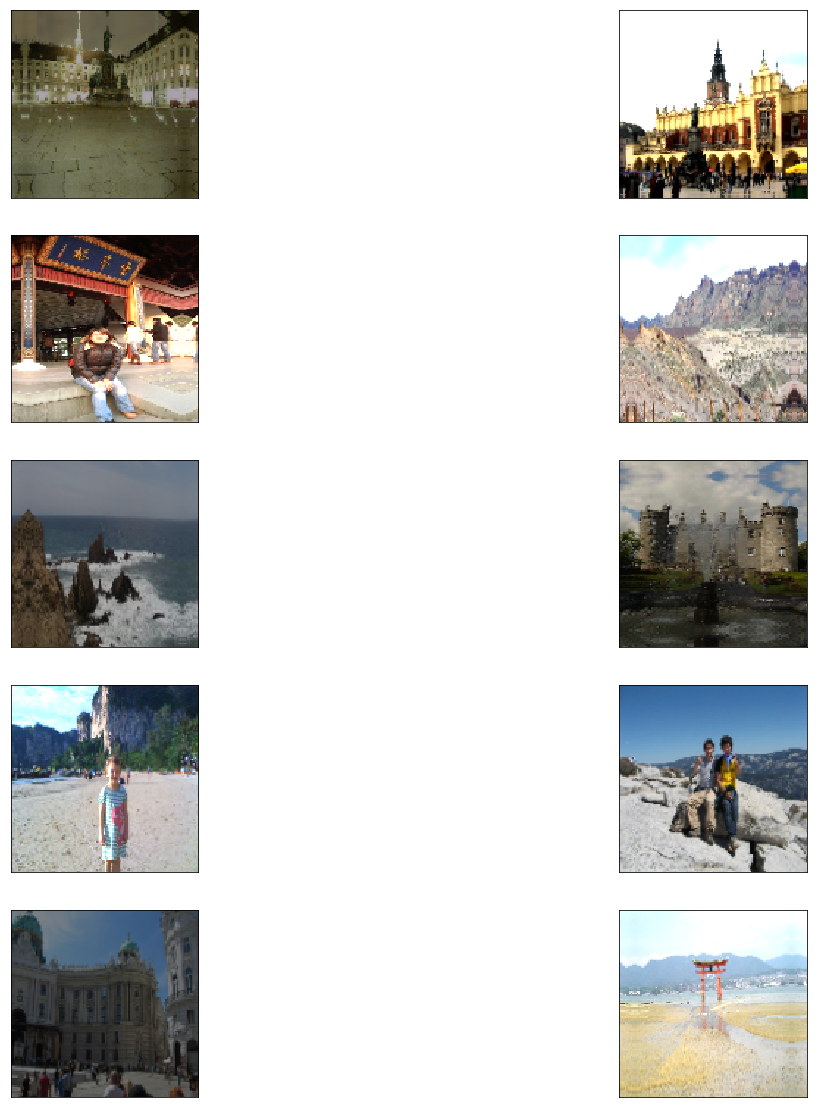

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = x_batch[i]
    image= image.astype(np.uint8)
    plt.imshow(image)

# Build The Network

In [0]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Conv3D, MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau

In [0]:
# !python -c 'import keras; import tensorflow; import sys; print("tensor : {}, keras: {}, python: {}".format(tensorflow.__version__, keras.__version__, sys.version))'

  File "<string>", line 1
    'import
          ^
SyntaxError: EOL while scanning string literal


**Methods for specific package's versions installations**

In [0]:
# import pkg_resources
# pkg_resources.require("Twisted==8.2.0")
# import twisted

# To determine which version you're using:
# !pip show tensorflow

# For the current version: 
# !pip install --upgrade tensorflow
# !pip install tensorflow --upgrade --force-reinstall


# For a specific version:
# !pip install tensorflow==1.2

# Build the model

In [0]:
model = Sequential()
model.add(Conv2D(64, (3,3), input_shape = (image_size[0], image_size[1], 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (5,5)))
model.add(Activation("sigmoid"))
model.add(MaxPooling2D(pool_size=(2,2)))

#Flatening the data
model.add(Flatten())
model.add(Dense(372))
model.add(Activation("relu"))

#output layer
model.add(Dense(100))
model.add(Activation('softmax'))

# Visualize the model

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
__________

In [0]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Train

Let us configure a loss function and optimizer.

The generator gives us in y a vector contains match percentages for each label, so we want to change it to show 0 or 1 using caregorical_crossentropy

In [0]:
# opt = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [0]:
model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
# model.compile(optimizer = opt,loss = "categorical_crossentropy", metrics=["accuracy"])

we calculate the amount of batches in an ephoch (For fitting the model)

In [0]:
step_size_train=train_generator.n//train_generator.batch_size
print("step_size_train :", step_size_train)
step_size_validation=validation_generator.n//validation_generator.batch_size
print("step_size_validation :", step_size_validation)

step_size_train : 3377
step_size_validation : 233


Fix for the error : 
OSError: image file is truncated (14 bytes not processed)

In [0]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True 

#https://stackoverflow.com/questions/12984426/python-pil-ioerror-image-file-truncated-with-big-images

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [0]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

We define an early stopper to avoid wasting compute resources and time

In [0]:
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=2, verbose=1, mode='auto')

In [0]:
import time

networkfileName = RESULTS_PATH + "/" + MODEL_NAME + "{}" + MODEL_ENDING.format(int(time.time()))
                      
checkpoint = ModelCheckpoint(networkfileName, monitor='val_acc', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

Now we train the model with fit_generator instead of regular fit.

In [0]:
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator,
                   validation_steps = step_size_validation,
                   epochs=15,
                   callbacks = [learning_rate_reduction],
                   verbose=1)

Epoch 1/5
  24/3377 [..............................] - ETA: 1:47:14 - loss: 15.9157 - acc: 0.0125

e:\projects\ml_project\venv\lib\site-packages\PIL\Image.py:953: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


3377/3377 [==============================] - 7019s 2s/step - loss: 15.8732 - acc: 0.0152 - val_loss: 15.8717 - val_acc: 0.0153
Epoch 2/5
3377/3377 [==============================] - 7020s 2s/step - loss: 15.8737 - acc: 0.0152 - val_loss: 15.8717 - val_acc: 0.0153
Epoch 3/5
3377/3377 [==============================] - 7014s 2s/step - loss: 15.8747 - acc: 0.0151 - val_loss: 15.8717 - val_acc: 0.0153
Epoch 4/5
3376/3377 [============================>.] - ETA: 1s - loss: 15.8737 - acc: 0.0152
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3377/3377 [==============================] - 7018s 2s/step - loss: 15.8737 - acc: 0.0152 - val_loss: 15.8717 - val_acc: 0.0153
Epoch 5/5
3377/3377 [==============================] - 7026s 2s/step - loss: 15.8744 - acc: 0.0151 - val_loss: 15.8717 - val_acc: 0.0153


# Examine the results

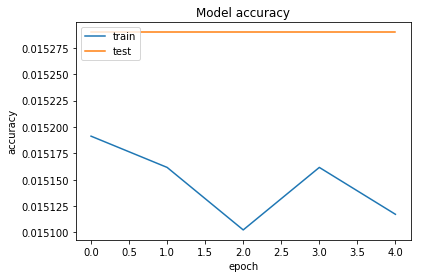

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

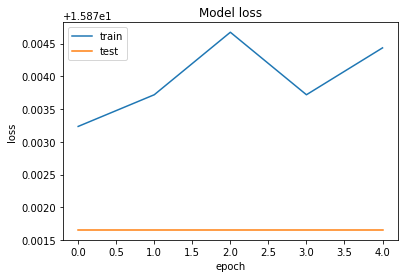

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save the model

Create results directory if it doesn't exist

In [0]:
import os
print(FULL_SAVING_PATH)

E:/Projects/ML_Project/Landmark_Kaggle_Challange/models/Our_NN_2.0.H5


In [0]:
if not os.path.exists(SAVING_DIR_PATH):
    os.makedirs(SAVING_DIR_PATH)

# while(os.path.exists(FULL_SAVING_PATH)):
#    print(FULL_SAVING_PATH, "already exists, creating new file name")
#    MODEL_VERSION = MODEL_VERSION + 0.1
#    FULL_SAVING_PATH = buildFullSavePath(model_version=MODEL_VERSION)

In [0]:
model.save(FULL_SAVING_PATH)  # creates a HDF5 file 'my_model.h5'

# Load the model from h5 file

load the model from the saved file

In [0]:
# from tensorflow.keras.models import load_model

# # returns a compiled model
# # identical to the previous one
# model = load_model(FULL_SAVING_PATH)

In [0]:
# train_loss, train_acc = model.evaluate(X,y)

In [0]:
# print("loss: ",train_loss, "acc: ",  train_acc)

# Test the model on the TestSet

Lets evaluate our model on the test set :


In [0]:
# train_loss, train_acc = model.evaluate(x_batch,y)

In [0]:
test_datagen=ImageDataGenerator()
test_generator=test_datagen.flow_from_directory(TEST_DATA_PATH,
                                                  target_size=image_size,
                                                  color_mode='rgb',
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

step_size_test=test_generator.n//test_generator.batch_size

test_loss, test_acc = model.evaluate_generator(generator=test_generator, 
                               steps=step_size_test)
                               


Found 18692 images belonging to 100 classes.


In [0]:
print(test_loss)
print(test_acc)

15.874770701569714
0.015096359979959575
